# How to characterize a transmission line using a qubit as a probe
**Characterize transmission-line bandwidth via probe measurements and the graph-based optimization engine**

The Boulder Opal optimization engine provides a large, modular collection of configuration options that allows it to be used for a range of tasks in quantum control, including estimating Hamiltonian parameters in a model using measured data. 

In this notebook, we show how the [optimization engine](https://docs.q-ctrl.com/references/boulder-opal/boulderopal/graph/run_optimization) can be used to determine the hardware parameters that impact the fidelity of control operations.  Specifically, we focus on estimating the bandwidth of transmission lines via probe measurements.

## Transmission-line-bandwidth characterization overview
Our task is to identify a linear filter that alters the shape of the pulses in the control line. By feeding different control pulses and then measuring the qubit, we are able to extract information about the parameters that characterize the filter. This setup is illustrated in the figure below.



To exemplify this procedure, we will consider a one-qubit system obeying the following Hamiltonian:

$$ H(t) = \frac{1}{2} \mathcal{L} \left[ \alpha(t) \right] \sigma_x, $$

where $\alpha(t)$ is a real time-dependent control pulse and $\mathcal{L}$ is a filter applied to the pulse.
This linear filter acts on the control pulse $\alpha(t)$ according to the convolution product with some kernel $K(t)$:

$$ \mathcal{L} \left[ \alpha(t) \right] = \int_0^t \mathrm{d} s \; \alpha(s) K(t-s). $$

To characterize this filter, we want to determine the parameters that provide the form of the kernel $K(t)$.

It is useful in many cases to approximate the linear filter using a Gaussian kernel characterized by two unknown parameters, a standard deviation $\sigma$ and a mean $\mu$:

$$ K(t) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left\{ - \frac{(t-\mu)^2}{2\sigma^2} \right\}. $$

The standard deviation $\sigma$ roughly represents the range of frequencies that the filter allows to pass, while the mean $\mu$ represents a time offset between when the pulses were intended to be generated and when they are actually produced. To estimate these two parameters, we will simulate the effect of this filter on a series of pulses and then use the simulated results to find the most likely form of the filter's kernel.


## Summary workflow



### 1. Perform measurements to probe the system

To estimate the parameters $\sigma$ and $\mu$, we subject our system to a series of Gaussian pulses with different standard deviations and delays, and measure their effect on the qubit. Each of these Gaussian wave packets will contain a different range of frequencies, and thus be differently affected by the linear filter. The different delay timings also result in a different effect of the pulses by the offset of the filter, as later pulses will have a larger portion of their area outside the time interval before the measurement. The values of the final measurements are then used to obtain an estimate of the parameters that characterize the filter.

As the Hamiltonian we are considering is proportional to $\sigma_x$, we will normalize all the Gaussian pulses to produce $\pi$ pulses, prepare the qubit initially in the state $|0 \rangle$, and measure the population in state $| 1 \rangle$. If no filter was present, the initial state would be flipped by the $\pi$ pulse and the population in state $|1 \rangle$ would be 1. Any deviations from this behavior represent the effect of the filter $\mathcal{L}$.

We will assume that the measurement results are given by some physical parameter (given in arbitrary units) linearly proportional to the population in the state $|1 \rangle$, but not necessarily the same, because the populations might not be directly accessible by the measurement apparatus. This results in two additional parameters that connect the measured results $M$ to the population $P_1$ of state $|1 \rangle$:

$$ M = a P_1 + b. $$

Together, $\sigma$, $\mu$, $a$, $b$ form the four variables that our optimization engine will attempt to determine.

### 2. Build a graph-based optimization encoding the problem
Next, you represent a cost function to be minimized using graphs.
Begin by defining the parameters that you want to estimate in the graph using the `graph.optimizable_scalar` or `graph.optimization_variable` operations.
If you have an idea of the expected value of the optimization variables, you can provide it in the form of `initial_values` for the optimization variable.
In this case, the parameter $a$ is expected to have a value close to 1, while the parameter $b$ is expected to have a value close to 0.

Construct the problem such that the optimizer will try to find the form of the evolution that would most closely match the measured points. Given a set of input points $M_i$ and the corresponding values $m_i$ that would be expected from a chosen set of the filter parameters $\sigma, \mu, a, b$, the cost function is:

$$ C = \sum_i \frac{[M_i-m_i(\sigma, \mu, a, b)]^2}{2(\Delta M_i)^2}, $$

where $\Delta M_i$ is the standard deviation of each of the measured input points $M_i$. Minimizing this cost function is equivalent to minimizing the negative log likelihood that a certain set of parameters $\sigma, \mu, a, b$ could generate the points $M_i$, for the case where the probability distribution of the errors is a Gaussian. In this case, the probability of a certain curve $m_i(\sigma, \mu, a, b)$ generating the points $M_i$ is the product of all the individual Gaussian probabilities:

$$ P = \prod_i \frac{1}{\sqrt{2\pi (\Delta M_i)^2}} \exp \left\{ - \frac{[M_i - m_i(\sigma, \mu, a, b)]^2}{2 (\Delta M_i)^2} \right\}. $$

It is easy to see that the negative logarithm of $P$ is the cost $C$ plus constants.

Execute the optimization using `boulderopal.run_optimization` by assigning the optimization variables to output nodes of the graph. Minimizing this cost gives us the best choice of parameters that generated the original dynamics of the system, and also allows us to calculate the precision of the estimated parameters. This is done by using the Cramér–Rao bound to identify the Hessian of the cost function with the inverse of the covariance matrix for the variables estimated.

## Example: Estimating the parameters of a Gaussian filter with simulated qubit measurements

The following code blocks begin by simulating the response of a qubit driven by a filtered pulse.  The results of this simulation are taken as proxy measurements on which we perform the system identification task below.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qctrlvisualizer as qv
import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

In [2]:
# Define parameters to be estimated
actual_sigma = 300e-9  # s
actual_mu = 100e-9  # s
actual_a = 1.7
actual_b = -0.5

total_duration = 1000e-9  # s

# Define parameters of the Gaussian pulses to probe the filter
max_width = total_duration / 6.0
mean_values = np.linspace(max_width, total_duration - max_width, 6)
width_values = np.linspace(max_width / 8.0, max_width / 2.0, 4)

# Define sampled times
segments = 150
t_values = np.linspace(0.0, total_duration, segments + 1)


def population(pulse_widths, pulse_means, filter_sigma, filter_mu):
    """
    Calculates the transfer probability between states |0> and |1> for a
    batch of Gaussian pulses with given widths and means, while applying
    a Gaussian filter to the pulses with a given cutoff frequency and offset.
    """

    def gaussian_pulse(t, mean, width):
        return np.exp(-0.5 * ((t - mean) / width) ** 2.0) * np.sqrt(
            0.5 * np.pi / width**2.0
        )

    graph = bo.Graph()

    alpha = graph.pwc_signal(
        gaussian_pulse(
            t_values[None, None, :],
            pulse_means[None, :, None],
            pulse_widths[:, None, None],
        ),
        total_duration,
    )

    shift_signal = graph.convolve_pwc(
        pwc=alpha,
        kernel=graph.gaussian_convolution_kernel(std=filter_sigma, offset=filter_mu),
    )
    shift = 0.5 * shift_signal * graph.pauli_matrix("X")

    population = 1.0 - graph.infidelity_stf(
        sample_times=t_values,
        hamiltonian=shift,
        target=graph.target(graph.pauli_matrix("M")),
    )
    population.name = "populations"

    graph_result = bo.execute_graph(graph=graph, output_node_names="populations")

    return graph_result["output"]["populations"]["value"]


populations = population(
    pulse_widths=width_values,
    pulse_means=mean_values,
    filter_mu=actual_mu,
    filter_sigma=actual_sigma,
)

Your task (action_id="1829408") has completed.


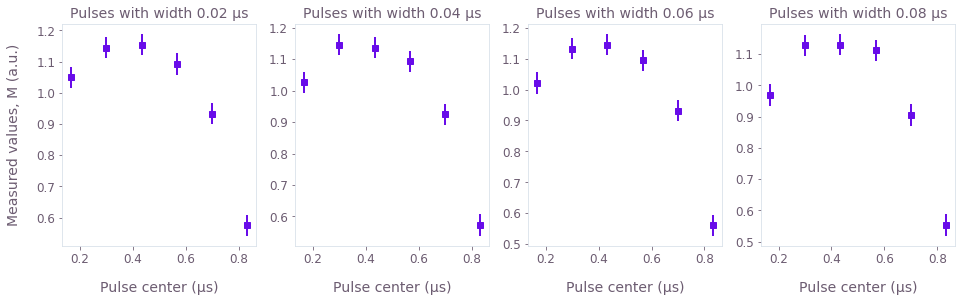

In [3]:
# Create measurement results with some uncertainty associated to them,
# we will estimate the standard deviation of this error as 1% of the population
population_errors = 0.01 * np.ones_like(populations)

measurement_results = (
    actual_a * np.random.normal(loc=populations, scale=population_errors) + actual_b
)

# Rescale error to arbitrary units
measurement_errors = np.abs(actual_a) * population_errors

# Plot inputs
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_ylabel("Measured values, M (a.u.)")
for n in range(len(width_values)):
    axs[n].set_title(f"Pulses with width {width_values[n] * 1e6:.2f} µs")
    axs[n].set_xlabel("Pulse center (µs)")
    axs[n].errorbar(
        mean_values * 1e6,
        measurement_results[n],
        yerr=2.0 * measurement_errors[n],
        fmt="s",
    )

plt.show()

Each of these graphs represents the average measurement results of a series of simulated experiments where the offset of the Gaussian $\pi$ pulses vary. In each graph the width of the Gaussian control pulse is different, as indicated in their titles. The measured values $M$ plotted above are linearly proportional to the populations $P_1$:

$$ M = a P_1 + b. $$

The measured values are assumed to be subject to errors with Gaussian probability distributions that have a standard deviation that is 1% of $a$. This means that we are assuming that the error in the value of the of the population is of about 1%. The error bars in the graphs represent two times the standard deviation, having therefore a reliability of 95%.

### Estimating the parameters of the filter

The next step involves performing an optimization in which the four unknown parameters are estimated. This is done by the optimizer by trying to find the form of the evolution that would most closely match the measured points. The optimization engine involves performing a simulation of system evolution in order to fit the measured data.

In [4]:
graph = bo.Graph()

# Parameters to estimate
mu = graph.optimizable_scalar(lower_bound=0.0, upper_bound=total_duration, name="mu")
sigma = graph.optimizable_scalar(
    lower_bound=total_duration / 100, upper_bound=total_duration, name="sigma"
)
a = graph.optimizable_scalar(
    lower_bound=-10.0, upper_bound=10.0, initial_values=1.0, name="a"
)
b = graph.optimizable_scalar(
    lower_bound=-10.0, upper_bound=10.0, initial_values=0.0, name="b"
)


# Define Gaussian pulse, normalized to generate pi-pulses
def gauss_pulse(t, mean, width):
    return graph.exp(-0.5 * ((t - mean) / width) ** 2.0) * graph.sqrt(
        0.5 * np.pi / width**2.0
    )


# Create Hamiltonian term
# Create a 2D batch of signals with all values of mean and width you want to simulate.
# This batch is preserved through the entire computation, which ends up being faster than
# looping through all values.
alpha = graph.pwc_signal(
    values=gauss_pulse(
        t_values[None, None, :], mean_values[None, :, None], width_values[:, None, None]
    ),
    duration=total_duration,
    name="alpha",
)

gaussian_kernel = graph.gaussian_convolution_kernel(std=sigma, offset=mu)
alpha_filtered = graph.convolve_pwc(pwc=alpha, kernel=gaussian_kernel)
shift = 0.5 * alpha_filtered * graph.pauli_matrix("X")

# Calculate |0> -> |1> transfer probability
calculated_populations = 1.0 - graph.infidelity_stf(
    sample_times=t_values,
    hamiltonian=shift,
    target=graph.target(graph.pauli_matrix("M")),
    name="infidelities",
)

# Create measured points
calculated_points = a * calculated_populations + b
calculated_points.name = "calculated_points"

# Calculate cost
cost = graph.sum(
    (calculated_points - measurement_results) ** 2.0 / (2.0 * measurement_errors**2.0),
    name="cost",
)

# Calculate Hessian
hessian = graph.hessian(cost, [mu, sigma, a, b], name="hessian")

In [5]:
# Estimate the parameters
result = bo.run_optimization(
    graph=graph,
    cost_node_name="cost",
    output_node_names=["mu", "sigma", "a", "b", "hessian"],
    optimization_count=10,
)

estimated_mu = result["output"]["mu"]["value"]
estimated_sigma = result["output"]["sigma"]["value"]
estimated_a = result["output"]["a"]["value"]
estimated_b = result["output"]["b"]["value"]

# Calculate 2-sigma uncertainties (error bars give 95% precision)
hessian = result["output"]["hessian"]["value"]
uncertainties = 2.0 * np.sqrt(np.diag(np.linalg.inv(hessian)))
uncertainty_mu, uncertainty_sigma, uncertainty_a, uncertainty_b = uncertainties

Your task (action_id="1829409") has started.
Your task (action_id="1829409") has completed.


In [6]:
mean_range = np.linspace(0.1 * total_duration, 0.9 * total_duration, 30)

calculated_curves = estimated_b + estimated_a * population(
    pulse_widths=width_values,
    pulse_means=mean_range,
    filter_mu=estimated_mu,
    filter_sigma=estimated_sigma,
)

ideal_curves = actual_b + actual_a * population(
    pulse_widths=width_values,
    pulse_means=mean_range,
    filter_mu=actual_mu,
    filter_sigma=actual_sigma,
)

Your task (action_id="1829410") has started.
Your task (action_id="1829410") has completed.
Your task (action_id="1829411") has completed.



actual sigma = 0.3 µs
estimated sigma = (0.300 ± 0.028) µs

actual mu = 0.1 µs
estimated mu = (0.097 ± 0.008) µs

actual a = 1.7 au
estimated a = (1.729 ± 0.100) au

actual b = -0.5 au
estimated b = (-0.531 ± 0.099) au


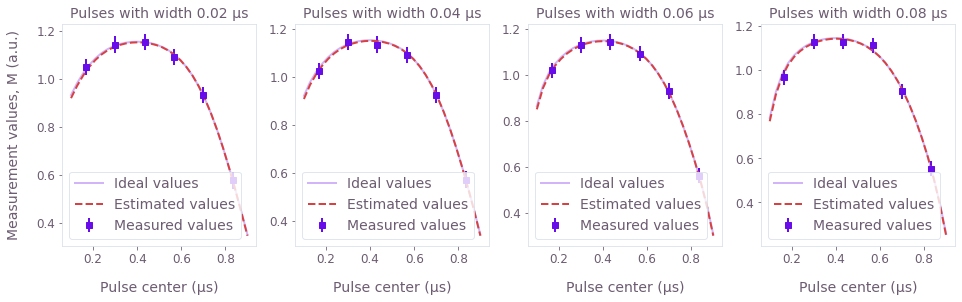

In [7]:
# Print parameter estimates
print(f"\nactual sigma = {actual_sigma/1e-6} µs")
print(
    f"estimated sigma = ({estimated_sigma/1e-6:.3f} ± {uncertainty_sigma/1e-6:.3f}) µs"
)

print(f"\nactual mu = {actual_mu/1e-6} µs")
print(f"estimated mu = ({estimated_mu/1e-6:.3f} ± {uncertainty_mu/1e-6:.3f}) µs")

print(f"\nactual a = {actual_a} au")
print(f"estimated a = ({estimated_a:.3f} ± {uncertainty_a:.3f}) au")

print(f"\nactual b = {actual_b} au")
print(f"estimated b = ({estimated_b:.3f} ± {uncertainty_b:.3f}) au")

# Plot results
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_ylabel("Measurement values, M (a.u.)")

for n in range(len(width_values)):
    axs[n].set_title(f"Pulses with width {width_values[n] * 1e6:.2f} µs")
    axs[n].set_xlabel("Pulse center (µs)")
    axs[n].errorbar(
        mean_values * 1e6,
        measurement_results[n],
        yerr=2.0 * measurement_errors[n],
        fmt="s",
        color="C0",
        label="Measured values",
    )
    axs[n].plot(
        mean_range * 1e6, ideal_curves[n], color="C0", label="Ideal values", alpha=0.3
    )
    axs[n].plot(
        mean_range * 1e6,
        calculated_curves[n],
        "--",
        label="Estimated values",
        color="C1",
    )
    axs[n].legend(loc=3)

plt.show()

In the graphs above, we can compare the curves that represent the values that would be measured if the system followed the estimated filter (dashed), and the values that would be measured if perfect measurements were performed on a system subject to the real filter (solid). Each graph corresponds to sets of experiments where pulses of the same width are applied at different points in time, as indicated in their titles and $x$ axis. The close match between the two curves highlights the fact that the estimated parameters are close to the real values.

Above we also provide explicit estimates of the parameters $\sigma$ (`sigma`) and $\mu$ (`mu`) of the Gaussian kernel of the linear filter.  The errors estimated for the variables above have a certainty of 2 times the standard deviation, or 95%.